<a href="https://colab.research.google.com/github/YvannD/NetworkU/blob/main/Forecasting_Model_Capstone_Project_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()  # upload your 3 CSVs

Saving purchase_invoices.csv to purchase_invoices (1).csv
Saving sales_invoices.csv to sales_invoices (1).csv
Saving bank_transactions.csv to bank_transactions (1).csv


In [15]:
# ==============================
#  CONFIG
# ==============================
CONFIG = {
    "horizon_days": 90,
    "start_date": "2025-01-01",
    "opening_cash": 7_400_000,  # you can change this
    "optimistic_sales_factor": 1.15,
    "pessimistic_sales_factor": 0.85,
    "optimistic_dso_shift": -5,
    "pessimistic_dso_shift": 5,
    "supplier_cost_stress": 0.10,  # +10% cost pessimistic
    "fx_rates": {"EUR":1.0, "USD":0.92, "JPY":0.006},
}


In [16]:
# Load files
sales = pd.read_csv("sales_invoices.csv")
purch = pd.read_csv("purchase_invoices.csv")
bank = pd.read_csv("bank_transactions.csv")

# Rename expected columns
sales = sales.rename(columns={
    "InvoiceDate":"issue_date",
    "DueDate":"due_date",
    "PaidDate":"payment_date",
    "Amount":"amount",
    "Currency":"currency"
})
purch = purch.rename(columns={
    "InvoiceDate":"issue_date",
    "DueDate":"due_date",
    "PaidDate":"payment_date",
    "Amount":"amount",
    "Currency":"currency"
})
bank = bank.rename(columns={
    "BookingDate":"date",
    "Amount":"amount",
    "Category":"category",
    "Type":"type",
    "Currency":"currency"
})

# Fill missing currency as EUR
for df in [sales, purch, bank]:
    if "currency" not in df.columns:
        df["currency"] = "EUR"

# Parse dates
date_cols = ["issue_date", "payment_date", "date"]
for df in [sales, purch, bank]:
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

# Convert all amounts to EUR (base currency)
def to_eur(row):
    rate = CONFIG["fx_rates"].get(row["currency"], 1)
    return row["amount"] * rate

sales["amount_eur"] = sales.apply(to_eur, axis=1)
purch["amount_eur"] = purch.apply(to_eur, axis=1)
bank["amount_eur"] = bank.apply(to_eur, axis=1)

# Infer type if missing
if "type" not in bank.columns:
    bank["type"] = bank["amount"].apply(lambda x: "credit" if x > 0 else "debit")

print("Sales sample:")
display(sales.head())
print("Purchases sample:")
display(purch.head())
print("Bank sample:")
display(bank.head())


Sales sample:


,invoice_id,customer,issue_date,due_date,currency,amount,status,payment_date,amount_eur
0,6000,Cust_A,2024-01-27,2024-03-12,EUR,7086.27,Paid,2024-03-15,7086.2700
1,6001,Cust_B,2024-07-13,2024-09-11,EUR,17643.68,Paid,2024-09-12,17643.6800
2,6002,Cust_A,2024-03-10,2024-04-24,EUR,13893.76,Paid,2024-04-29,13893.7600
3,6003,Cust_C,2024-08-11,2024-09-10,USD,15110.81,Paid,2024-09-10,13901.9452
4,6004,Cust_B,2024-08-17,2024-09-16,JPY,2150279.00,Paid,2024-09-20,12901.6740


Purchases sample:


,invoice_id,vendor,issue_date,due_date,currency,amount,status,payment_date,amount_eur
0,9000,Vend_B,2024-05-24,2024-06-23,EUR,2944.84,Paid,2024-06-30,2944.84
1,9001,Vend_B,2024-06-20,2024-08-19,EUR,14631.95,Paid,2024-09-10,14631.95
2,9002,Vend_C,2024-03-11,2024-04-10,EUR,11122.68,Paid,2024-04-17,11122.68
3,9003,Vend_B,2024-11-05,2024-12-05,EUR,3362.55,Paid,2024-12-05,3362.55
4,9004,Vend_A,2024-03-25,2024-05-24,EUR,10565.33,Paid,2024-06-16,10565.33


Bank sample:


,tx_id,date,account,currency,type,amount,category,counterparty,amount_eur
0,1,2024-01-01,EUR_Operating,EUR,debit,2944.84,Supplier Payment,Vend_B,2944.84
1,2,2024-01-01,EUR_Operating,EUR,debit,31161.67,Loan Interest,Bank Loan,31161.67
2,3,2024-01-02,EUR_Operating,EUR,debit,18.14,Bank Fee,Bank,18.14
3,4,2024-01-03,EUR_Operating,EUR,debit,8110.71,Supplier Payment,Vend_A,8110.71
4,5,2024-01-04,EUR_Operating,EUR,debit,5805.73,Supplier Payment,Vend_B,5805.73


In [17]:
def detect_recurring_items(bank, min_occ=3, max_cv=0.3):
    patterns = []
    grouped = bank.groupby(["category", "type"])

    for (cat, t), grp in grouped:
        if len(grp) < min_occ:
            continue

        mu = grp["amount_eur"].mean()
        sigma = grp["amount_eur"].std()

        if mu == 0 or pd.isna(sigma):
            continue

        cv = abs(sigma / mu)
        if cv <= max_cv:  # stable pattern
            avg_day = int(round(grp["date"].dt.day.mean()))
            patterns.append({
                "category": cat,
                "type": t,
                "avg_amount": mu,
                "day": avg_day
            })

    return patterns

recurring_patterns = detect_recurring_items(bank)
recurring_patterns


[{'category': 'Loan Interest',
  'type': 'debit',
  'avg_amount': np.float64(29742.2225),
  'day': 1},
 {'category': 'Payroll',
  'type': 'debit',
  'avg_amount': np.float64(123206.88333333335),
  'day': 25},
 {'category': 'Transfer to Payroll',
  'type': 'debit',
  'avg_amount': np.float64(123206.88333333335),
  'day': 25}]

In [18]:
def compute_dso_dpo(sales, purch):
    dsodf = sales.dropna(subset=["issue_date", "payment_date"]).copy()
    dpodf = purch.dropna(subset=["issue_date", "payment_date"]).copy()

    dsodf["dso"] = (dsodf["payment_date"] - dsodf["issue_date"]).dt.days
    dpodf["dpo"] = (dpodf["payment_date"] - dpodf["issue_date"]).dt.days

    return int(dsodf["dso"].mean()), int(dpodf["dpo"].mean())

DSO, DPO = compute_dso_dpo(sales, purch)
DSO, DPO


(55, 56)

In [19]:
def forecast_issuance(df, start_date, horizon):
    """Weekday seasonality forecast like Agicap."""
    df = df.dropna(subset=["issue_date"])
    df["weekday"] = df["issue_date"].dt.weekday
    avg_by_weekday = df.groupby("weekday")["amount_eur"].mean()

    future_dates = pd.date_range(start=start_date, periods=horizon, freq="D")
    forecast = []

    for d in future_dates:
        wd = d.weekday()
        forecast.append(avg_by_weekday.get(wd, 0))

    return pd.Series(forecast, index=future_dates)

def shift_by_days(series, days):
    shifted = series.copy()
    shifted.index = shifted.index + pd.Timedelta(days=days)
    return shifted

def build_recurring(start_date, horizon, patterns):
    dates = pd.date_range(start=start_date, periods=horizon, freq="D")
    ser = pd.Series(0, index=dates)

    for p in patterns:
        for d in dates:
            if d.day == p["day"]:
                amt = p["avg_amount"]
                ser.loc[d] += amt if p["type"] == "credit" else -amt
    return ser

def build_forecast(sales_factor, dso_shift, cost_stress):
    start = pd.to_datetime(CONFIG["start_date"])
    H = CONFIG["horizon_days"]

    # 1) invoice issuance
    sales_iss = forecast_issuance(sales, start, H) * sales_factor
    purch_iss = forecast_issuance(purch, start, H) * (1 + cost_stress)

    # 2) cash actualization
    cash_in = shift_by_days(sales_iss, DSO + dso_shift)
    cash_out = shift_by_days(purch_iss, DPO)

    # 3) recurring flows
    rec = build_recurring(start, H, recurring_patterns)

    # 4) combine
    dates = pd.date_range(start=start, periods=H, freq="D")
    total_in = cash_in.reindex(dates).fillna(0) + rec.clip(lower=0)
    total_out = cash_out.abs().reindex(dates).fillna(0) + (-rec.clip(upper=0))

    net = total_in - total_out
    cum = CONFIG["opening_cash"] + net.cumsum()

    return pd.DataFrame({
        "In": total_in,
        "Out": total_out,
        "Net": net,
        "Cash": cum
    })


In [20]:
base = build_forecast(
    sales_factor=1.0,
    dso_shift=0,
    cost_stress=0
)

optimistic = build_forecast(
    sales_factor=CONFIG["optimistic_sales_factor"],
    dso_shift=CONFIG["optimistic_dso_shift"],
    cost_stress=0
)

pessimistic = build_forecast(
    sales_factor=CONFIG["pessimistic_sales_factor"],
    dso_shift=CONFIG["pessimistic_dso_shift"],
    cost_stress=CONFIG["supplier_cost_stress"]
)


/tmp/ipython-input-3284614988.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-29742.2225' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ser.loc[d] += amt if p["type"] == "credit" else -amt
/tmp/ipython-input-3284614988.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-29742.2225' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ser.loc[d] += amt if p["type"] == "credit" else -amt
/tmp/ipython-input-3284614988.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-29742.2225' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ser.loc[d] += amt if p["type"] == "credit" else -amt


In [21]:
def analyze_liquidity(df):
    min_cash = df["Cash"].min()
    min_date = df["Cash"].idxmin()

    surplus_windows = df[df["Net"] > 0].index
    deficit_windows = df[df["Net"] < 0].index

    return {
        "min_cash": min_cash,
        "min_date": min_date,
        "surplus_days": len(surplus_windows),
        "deficit_days": len(deficit_windows)
    }

{
 "Base": analyze_liquidity(base),
 "Optimistic": analyze_liquidity(optimistic),
 "Pessimistic": analyze_liquidity(pessimistic)
}


{'Base': {'min_cash': 6675412.974392177,
  'min_date': Timestamp('2025-03-25 00:00:00'),
  'surplus_days': 32,
  'deficit_days': 6},
 'Optimistic': {'min_cash': 6769870.52692316,
  'min_date': Timestamp('2025-03-25 00:00:00'),
  'surplus_days': 37,
  'deficit_days': 6},
 'Pessimistic': {'min_cash': 6577907.173023516,
  'min_date': Timestamp('2025-03-25 00:00:00'),
  'surplus_days': 29,
  'deficit_days': 9}}

/tmp/ipython-input-29757296.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  base_m = base["Cash"].resample("M").last()
/tmp/ipython-input-29757296.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  opt_m = optimistic["Cash"].resample("M").last()
/tmp/ipython-input-29757296.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pes_m = pessimistic["Cash"].resample("M").last()


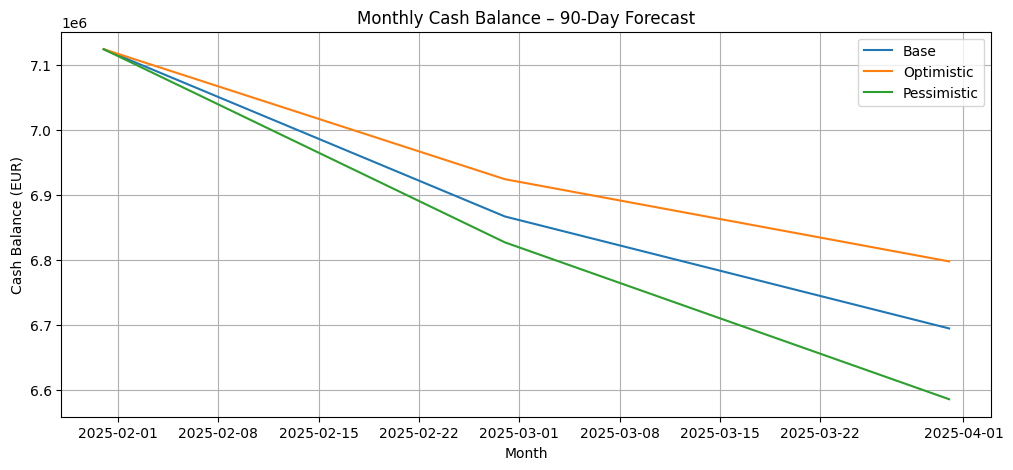

In [22]:
# === MONTHLY CASH BALANCE – 90 DAY FORECAST ===
base_m = base["Cash"].resample("M").last()
opt_m = optimistic["Cash"].resample("M").last()
pes_m = pessimistic["Cash"].resample("M").last()

plt.figure(figsize=(12, 5))
plt.plot(base_m.index, base_m.values, label="Base")
plt.plot(opt_m.index, opt_m.values, label="Optimistic")
plt.plot(pes_m.index, pes_m.values, label="Pessimistic")
plt.title("Monthly Cash Balance – 90-Day Forecast")
plt.xlabel("Month")
plt.ylabel("Cash Balance (EUR)")
plt.grid(True)
plt.legend()
plt.show()


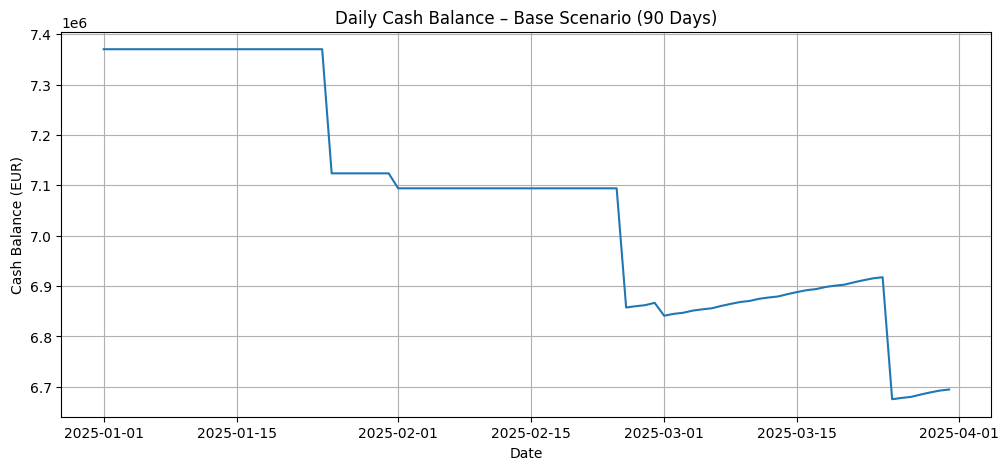

In [23]:
# === DAILY CASH BALANCE – BASE SCENARIO ===
plt.figure(figsize=(12, 5))
plt.plot(base.index, base["Cash"])
plt.title("Daily Cash Balance – Base Scenario (90 Days)")
plt.xlabel("Date")
plt.ylabel("Cash Balance (EUR)")
plt.grid(True)
plt.show()


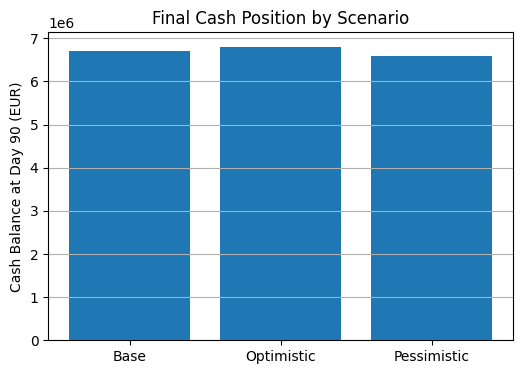

In [26]:
# === FINAL CASH PER SCENARIO (BAR CHART) ===
final_cash = [
    base["Cash"].iloc[-1],
    optimistic["Cash"].iloc[-1],
    pessimistic["Cash"].iloc[-1]
]
labels = ["Base", "Optimistic", "Pessimistic"]

plt.figure(figsize=(6, 4))
plt.bar(labels, final_cash)
plt.title("Final Cash Position by Scenario")
plt.ylabel("Cash Balance at Day 90 (EUR)")
plt.grid(True, axis="y")
plt.show()
